In [27]:
import pandas as pd 

In [28]:
# Time frame for forecasts_and_truth is 2021-01 ~ 2022-05
df_1 = pd.read_csv('forecasts_and_truth.csv')
display(df_1.head())

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.0,Observed Data (NYTimes),1630,710.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.0,Observed Data (NYTimes),86,0.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.0,Observed Data (NYTimes),1374,40.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.0,Observed Data (NYTimes),485,151.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.0,Observed Data (NYTimes),8625,883.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475


In [29]:
# We take inc case (number of cases) for our dependent variable
df_1 = df_1[df_1['target_variable'] == 'inc case']
display(df_1.head())

,target_variable,target_end_date,location,location_name,temporal_resolution,population,geo_type,geo_value,abbreviation,full_location_name,...,type,forecast_value,truth_source,truth_value,abs_error,forecast_week,target_week,model_type,model_type.general,abs_error_per10k.pop
0,inc case,2020-04-11,01,Alabama,wk,4903185,state,al,AL,Alabama,...,point,920.0,Observed Data (NYTimes),1630,710.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,1.448038
1,inc case,2020-04-11,02,Alaska,wk,731545,state,ak,AK,Alaska,...,point,86.0,Observed Data (NYTimes),86,0.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.000000
2,inc case,2020-04-11,04,Arizona,wk,7278717,state,az,AZ,Arizona,...,point,1414.0,Observed Data (NYTimes),1374,40.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.054955
3,inc case,2020-04-11,05,Arkansas,wk,3017804,state,ar,AR,Arkansas,...,point,334.0,Observed Data (NYTimes),485,151.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.500364
4,inc case,2020-04-11,06,California,wk,39512223,state,ca,CA,California,...,point,7742.0,Observed Data (NYTimes),8625,883.0,1,2,parametric-time.series-RW.first.difference,parametric-time.series,0.223475


In [30]:
# Rename the column 'state_abbreviation' to 'abbreviation'
df_1 = df_1.rename(columns={'abbreviation': 'location_key'})

df_1['location_key'] = 'US_' + df_1['location_key'].astype(str)

df_1.dropna(subset=['truth_value'], inplace=True)

# Create a list of column names to keep
columns_to_keep = ['location_key', 'population', 'truth_value', 'target_end_date']
# Select only the specified columns
df_1 = df_1[columns_to_keep]

# Convert the 'target_end_date' column to datetime
df_1['target_end_date'] = pd.to_datetime(df_1['target_end_date'])
# Extract the month from the 'target_end_date' column
df_1['date'] = df_1['target_end_date'].dt.to_period('M')
df_1.drop(columns=['target_end_date'], inplace=True)

# Take data from 2021-01 to 2022-05
start_date = '2021-01'
end_date = '2022-05'

date_mask = (df_1['date'] >= start_date) & (df_1['date'] <= end_date)
df_1 = df_1[date_mask]

display(df_1)

,location_key,population,truth_value,date
162415,US_AL,4903185,26000,2021-01
162416,US_AL,4903185,26000,2021-01
162417,US_AL,4903185,26000,2021-01
162418,US_AL,4903185,26000,2021-01
162419,US_AL,4903185,26000,2021-01
...,...,...,...,...
630902,US_US,332875137,505770,2022-05
630903,US_US,332875137,505770,2022-05
630904,US_US,332875137,505770,2022-05
630905,US_US,332875137,505770,2022-05


In [31]:
# Group by state abbreviation and date - then take the average of the truth value
# Average truth value is the number of covid cases on average per state
# Take the average population of each state per month
cases_per_state = df_1.groupby(['location_key', 'date']).agg({'truth_value': 'mean', 'population': 'mean'}).reset_index()
cases_per_state = cases_per_state.rename(columns={'truth_value': 'average_count'})

#round the number of average count
cases_per_state['average_count'] = cases_per_state['average_count'].round()

state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}
cases_per_state['location_key'] = cases_per_state['location_key'].map(state_mapping)
cases_per_state.dropna(inplace=True)
display(cases_per_state.head())

,location_key,date,average_count,population
0,Alaska,2021-01,1741.0,731545.0
1,Alaska,2021-02,999.0,731545.0
2,Alaska,2021-03,974.0,731545.0
3,Alaska,2021-04,1194.0,731545.0
4,Alaska,2021-05,618.0,731545.0


In [32]:
index_df = pd.read_csv('index.csv')
display(index_df.head())

,location_key,place_id,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
0,AD,ChIJlfCemC71pRIRkn_qeNc-yQc,Q228,country/AND,AD,Andorra,NaN,NaN,NaN,NaN,NaN,NaN,AD,AND,0
1,AE,ChIJvRKrsd9IXj4RpwoIwFYv0zM,Q878,country/ARE,AE,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,AE,ARE,0
2,AF,ChIJbQL_-LZu0TgReNqWvg1GtfM,Q889,country/AFG,AF,Afghanistan,NaN,NaN,NaN,NaN,NaN,NaN,AF,AFG,0
3,AF_BAL,ChIJWZOescNSyzgRkmVJ8fmfR3k,Q121104,NaN,AF,Afghanistan,BAL,Balkh,NaN,NaN,NaN,NaN,AF,AFG,1
4,AF_BAM,ChIJw-bKQwDr0jgRQiw8jHsQ-HI,Q171382,NaN,AF,Afghanistan,BAM,Bamyan,NaN,NaN,NaN,NaN,AF,AFG,1


In [33]:
# Drop rows with missing values in the 'location_key' column
index_df = index_df.dropna(subset=['location_key'])

# Filter rows with 'US_' prefix in the 'location_key' column
index_df = index_df[index_df['location_key'].str.startswith('US_')]

# Display the filtered DataFrame
display(index_df.head())

,location_key,place_id,wikidata_id,datacommons_id,country_code,country_name,subregion1_code,subregion1_name,subregion2_code,subregion2_name,locality_code,locality_name,iso_3166_1_alpha_2,iso_3166_1_alpha_3,aggregation_level
19558,US_AK,ChIJG8CuwJzfAFQRNduKqSde27w,Q797,geoId/02,US,United States of America,AK,Alaska,NaN,NaN,NaN,NaN,US,USA,1
19559,US_AK_02013,ChIJ7a-UgVuW_lYRjTetzbIWL48,Q504371,geoId/02013,US,United States of America,AK,Alaska,02013,Aleutians East,NaN,NaN,US,USA,2
19560,US_AK_02016,ChIJI9ivbI1Pg1cRg8d4nlGjGVU,Q185533,geoId/02016,US,United States of America,AK,Alaska,02016,Aleutians West,NaN,NaN,US,USA,2
19561,US_AK_02020,ChIJQT-zBHaRyFYR42iEp1q6fSU,Q39450,geoId/02020,US,United States of America,AK,Alaska,02020,Anchorage Municipality,NaN,NaN,US,USA,2
19562,US_AK_02050,ChIJAzKaLtLCIVcR4HXf_qNNZmk,Q500312,geoId/02050,US,United States of America,AK,Alaska,02050,Bethel,NaN,NaN,US,USA,2


In [34]:
# Time frame for Global_vaccination_search_insights.csv is 2021-01 ~ 2024-01
vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')
display(vaccination_search_df.head())

/var/folders/d6/qmvkgm9x2kq_2htc9f1yhtb00000gn/T/ipykernel_39778/858233779.py:2: DtypeWarning: Columns (5,8) have mixed types. Specify dtype option on import or set low_memory=False.
  vaccination_search_df = pd.read_csv('Global_vaccination_search_insights.csv')


,date,country_region,country_region_code,sub_region_1,sub_region_1_code,sub_region_2,sub_region_2_code,sub_region_3,sub_region_3_code,place_id,sni_covid19_vaccination,sni_vaccination_intent,sni_safety_side_effects
0,2021-01-04,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,31.019,7.318,5.726
1,2021-01-11,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,34.325,10.416,4.572
2,2021-01-18,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,33.666,9.689,5.406
3,2021-01-25,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,37.693,10.678,6.204
4,2021-02-01,United States,US,Alabama,US-AL,Autauga County,1001.0,NaN,NaN,ChIJg9z7ewWPjogRA_8QrB0va7o,45.849,13.942,7.218


In [35]:
vaccination_search_df['date'] = pd.to_datetime(vaccination_search_df['date'])
vaccination_search_df['date'] = vaccination_search_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
start_date = '2021-01'
end_date = '2022-05'

date_mask = (vaccination_search_df['date'] >= start_date) & (vaccination_search_df['date'] <= end_date)
vaccination_search_df = vaccination_search_df[date_mask]

# Group by 'sub_region_1' and calculate the mean of 'sni_covid19_vaccination'
vaccination_search_df = vaccination_search_df.groupby(['sub_region_1', 'date'])['sni_covid19_vaccination'].mean().reset_index()

# Assuming vaccination_df_filtered is the DataFrame containing data for the 51 US states

# Rename the column 'old_column_name' to 'new_column_name'
vaccination_search_df = vaccination_search_df.rename(columns={'sub_region_1': 'location_key'})

# Print the DataFrame to verify the changes
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1729,Yukon,2022-01,82.347600
1730,Yukon,2022-02,37.905000
1731,Yukon,2022-03,23.877500
1732,Yukon,2022-04,25.379500


In [36]:
# List of US states
us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida',
    'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine',
    'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
    'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
    'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas',
    'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

# Filter the DataFrame to include only the US states
vaccination_search_df = vaccination_search_df[vaccination_search_df['location_key'].isin(us_states)]

# Now df_us_states contains only the rows corresponding to the US states
display(vaccination_search_df)

,location_key,date,sni_covid19_vaccination
0,Alabama,2021-01,37.048310
1,Alabama,2021-02,47.069826
2,Alabama,2021-03,53.624391
3,Alabama,2021-04,39.750964
4,Alabama,2021-05,22.192073
...,...,...,...
1712,Wyoming,2022-01,32.042965
1713,Wyoming,2022-02,9.253333
1714,Wyoming,2022-03,7.990414
1715,Wyoming,2022-04,7.072492


In [37]:
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])
display(merged_df)

,location_key,date,average_count,population,sni_covid19_vaccination
0,Alaska,2021-01,1741.0,731545.0,60.884896
1,Alaska,2021-02,999.0,731545.0,55.116815
2,Alaska,2021-03,974.0,731545.0,74.260342
3,Alaska,2021-04,1194.0,731545.0,52.763595
4,Alaska,2021-05,618.0,731545.0,37.155872
...,...,...,...,...,...
845,Wyoming,2022-01,5892.0,578759.0,32.042965
846,Wyoming,2022-02,2546.0,578759.0,9.253333
847,Wyoming,2022-03,291.0,578759.0,7.990414
848,Wyoming,2022-04,99.0,578759.0,7.072492


In [38]:
#Time frame for vaccination.csv is 2021-01 ~ 2022-09
vaccination_df = pd.read_csv('vaccinations.csv')
display(vaccination_df)

,date,location_key,new_persons_vaccinated,cumulative_persons_vaccinated,new_persons_fully_vaccinated,cumulative_persons_fully_vaccinated,new_vaccine_doses_administered,cumulative_vaccine_doses_administered,new_persons_vaccinated_pfizer,cumulative_persons_vaccinated_pfizer,...,new_persons_fully_vaccinated_janssen,cumulative_persons_fully_vaccinated_janssen,new_vaccine_doses_administered_janssen,cumulative_vaccine_doses_administered_janssen,new_persons_vaccinated_sinovac,total_persons_vaccinated_sinovac,new_persons_fully_vaccinated_sinovac,total_persons_fully_vaccinated_sinovac,new_vaccine_doses_administered_sinovac,total_vaccine_doses_administered_sinovac
0,2021-01-25,AD,NaN,576.0,NaN,NaN,NaN,576.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-02-01,AD,460.0,1036.0,NaN,NaN,460.0,1036.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-02-10,AD,255.0,1291.0,NaN,NaN,255.0,1291.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-02-12,AD,331.0,1622.0,NaN,NaN,331.0,1622.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-02-19,AD,519.0,2141.0,NaN,NaN,519.0,2141.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545113,2022-08-21,ZW,365.0,6400632.0,416.0,4715815.0,2011.0,12105303.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545114,2022-08-24,ZW,3621.0,6404253.0,3488.0,4719303.0,15923.0,12121226.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545115,2022-08-25,ZW,3684.0,6407937.0,2897.0,4722200.0,12159.0,12133385.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2545116,2022-08-27,ZW,3069.0,6411006.0,2899.0,4725099.0,12206.0,12145591.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
vaccination_df['date'] = pd.to_datetime(vaccination_df['date'])
vaccination_df['date'] = vaccination_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (vaccination_df['date'] >= start_date) & (vaccination_df['date'] <= end_date)
vaccination_df = vaccination_df[date_mask]

vaccination_df = vaccination_df.dropna(subset=['location_key'])

# Take rows with the states within the US
vaccination_df = vaccination_df[vaccination_df['location_key'].str.startswith('US_')]

# Take the last value per state, since it is the cumulative number of vaccinated people
vaccination_df = vaccination_df.groupby(['location_key', 'date'])['new_persons_vaccinated'].mean().reset_index()

# Rename the location_key values to state name
vaccination_df['location_key'] = vaccination_df['location_key'].map(state_mapping)
vaccination_df.dropna(inplace=True)

display(vaccination_df.head())

,location_key,date,new_persons_vaccinated
0,Alaska,2021-01,4525.187500
1,Alaska,2021-02,2660.962963
2,Alaska,2021-03,2644.387097
3,Alaska,2021-04,1889.466667
4,Alaska,2021-05,1031.354839


In [40]:
"""
demographics_df = pd.read_csv('demographics.csv')

demographics_df = demographics_df.dropna(subset=['location_key'])
demographics_df = demographics_df[demographics_df['location_key'].str.startswith('US_')]
demographics_df = demographics_df.iloc[:, :4]

display(demographics_df)"""

"\ndemographics_df = pd.read_csv('demographics.csv')\n\ndemographics_df = demographics_df.dropna(subset=['location_key'])\ndemographics_df = demographics_df[demographics_df['location_key'].str.startswith('US_')]\ndemographics_df = demographics_df.iloc[:, :4]\n\ndisplay(demographics_df)"

In [41]:
# Time frame for oxford-government-response.csv is 2020-01 ~ 2022-07
government_df = pd.read_csv('oxford-government-response (1).csv')
display(government_df.head())

,date,location_key,school_closing,workplace_closing,cancel_public_events,restrictions_on_gatherings,public_transport_closing,stay_at_home_requirements,restrictions_on_internal_movement,international_travel_controls,...,fiscal_measures,international_support,public_information_campaigns,testing_policy,contact_tracing,emergency_investment_in_healthcare,investment_in_vaccines,facial_coverings,vaccination_policy,stringency_index
0,2020-01-01,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,AD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Drop all columns except location_key, date, and stringency_index
columns_to_keep = ['location_key', 'date', 'stringency_index']
government_df = government_df[columns_to_keep]

government_df['date'] = pd.to_datetime(government_df['date'])
government_df['date'] = government_df['date'].dt.to_period('M')

# Take data from 2021-01 to 2022-05
date_mask = (government_df['date'] >= start_date) & (government_df['date'] <= end_date)
government_df = government_df[date_mask]

government_df = government_df.dropna(subset=['location_key'])
government_df = government_df[government_df['location_key'].str.startswith('US_')]
state_mapping = {
    'US_AL': 'Alabama',
    'US_AK': 'Alaska',
    'US_AZ': 'Arizona',
    'US_AR': 'Arkansas',
    'US_CA': 'California',
    'US_CO': 'Colorado',
    'US_CT': 'Connecticut',
    'US_DE': 'Delaware',
    'US_FL': 'Florida',
    'US_GA': 'Georgia',
    'US_HI': 'Hawaii',
    'US_ID': 'Idaho',
    'US_IL': 'Illinois',
    'US_IN': 'Indiana',
    'US_IA': 'Iowa',
    'US_KS': 'Kansas',
    'US_KY': 'Kentucky',
    'US_LA': 'Louisiana',
    'US_ME': 'Maine',
    'US_MD': 'Maryland',
    'US_MA': 'Massachusetts',
    'US_MI': 'Michigan',
    'US_MN': 'Minnesota',
    'US_MS': 'Mississippi',
    'US_MO': 'Missouri',
    'US_MT': 'Montana',
    'US_NE': 'Nebraska',
    'US_NV': 'Nevada',
    'US_NH': 'New Hampshire',
    'US_NJ': 'New Jersey',
    'US_NM': 'New Mexico',
    'US_NY': 'New York',
    'US_NC': 'North Carolina',
    'US_ND': 'North Dakota',
    'US_OH': 'Ohio',
    'US_OK': 'Oklahoma',
    'US_OR': 'Oregon',
    'US_PA': 'Pennsylvania',
    'US_RI': 'Rhode Island',
    'US_SC': 'South Carolina',
    'US_SD': 'South Dakota',
    'US_TN': 'Tennessee',
    'US_TX': 'Texas',
    'US_UT': 'Utah',
    'US_VT': 'Vermont',
    'US_VA': 'Virginia',
    'US_WA': 'Washington',
    'US_WV': 'West Virginia',
    'US_WI': 'Wisconsin',
    'US_WY': 'Wyoming'
}
government_df['location_key'] = government_df['location_key'].map(state_mapping)
display(government_df.head())

,location_key,date,stringency_index
246828,Alaska,2021-01,61.57
246829,Alaska,2021-01,61.57
246830,Alaska,2021-01,61.57
246831,Alaska,2021-01,61.57
246832,Alaska,2021-01,61.57


In [43]:
# Take the average of the stringency index per state
government_df = government_df.groupby(['location_key', 'date'])['stringency_index'].mean().reset_index()
display(government_df)

#df_unique = government_df.drop_duplicates(subset=['location_key'])
# Print the DataFrame with only one row for each unique location key
#display(df_unique)

,location_key,date,stringency_index
0,Alabama,2021-01,44.775484
1,Alabama,2021-02,46.300000
2,Alabama,2021-03,45.403226
3,Alabama,2021-04,37.962667
4,Alabama,2021-05,34.260000
...,...,...,...
845,Wyoming,2022-01,37.960000
846,Wyoming,2022-02,39.743929
847,Wyoming,2022-03,39.810000
848,Wyoming,2022-04,39.810000


In [44]:
# Display the shapes of DataFrames before merging
print("Shape of vaccination_search_df:", vaccination_search_df.shape)
print("Shape of vaccination_df:", vaccination_df.shape)
print("Shape of government_df:", government_df.shape)

Shape of vaccination_search_df: (850, 3)
Shape of vaccination_df: (850, 3)
Shape of government_df: (850, 3)


In [45]:
# Merge vaccination_search, vaccination, government_response, loaction_key, and cases
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])

# Merge the resulting dataframe with vaccination_df on the 'location_key' and 'date' column
merged_df = pd.merge(merged_df, vaccination_df, on=['location_key', 'date'])
merged_df_final = pd.merge(merged_df, government_df, on=['location_key', 'date'])

merged_df_final.dropna(inplace=True)

# Display the resulting DataFrame
display(merged_df_final)

,location_key,date,average_count,population,sni_covid19_vaccination,new_persons_vaccinated,stringency_index
0,Alaska,2021-01,1741.0,731545.0,60.884896,4525.187500,60.018387
1,Alaska,2021-02,999.0,731545.0,55.116815,2660.962963,57.870000
2,Alaska,2021-03,974.0,731545.0,74.260342,2644.387097,50.406452
3,Alaska,2021-04,1194.0,731545.0,52.763595,1889.466667,46.763333
4,Alaska,2021-05,618.0,731545.0,37.155872,1031.354839,42.130000
...,...,...,...,...,...,...,...
845,Wyoming,2022-01,5892.0,578759.0,32.042965,256.870968,37.960000
846,Wyoming,2022-02,2546.0,578759.0,9.253333,156.214286,39.743929
847,Wyoming,2022-03,291.0,578759.0,7.990414,75.064516,39.810000
848,Wyoming,2022-04,99.0,578759.0,7.072492,81.366667,39.810000


In [46]:
# Merge demographics_df and government_df on the 'location_key' column
#merged_df_final = pd.merge(merged_df, df_unique, on='location_key')
#merged_df_final.dropna(inplace=True)
# Merge the resulting DataFrame with df_1 on the 'location_key' column
#merged_df = pd.merge(merged_df, df_1, on='location_key')

# Display the resulting DataFrame
#display(merged_df_final)

### Linear regression model

In [47]:
import statsmodels.api as sm

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)

merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['population', 'sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index'] + state_dummies.columns.tolist()].astype(float) 
y = merged_df_final['average_count']

# Add a constant to the features to account for the intercept in the model
X = sm.add_constant(X)

# Fit the model
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          average_count   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.259
Method:                 Least Squares   F-statistic:                     6.717
Date:                Tue, 27 Feb 2024   Prob (F-statistic):           2.71e-36
Time:                        12:46:46   Log-Likelihood:                -9974.9
No. Observations:                 850   AIC:                         2.006e+04
Df Residuals:                     797   BIC:                         2.031e+04
Df Model:                          52                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                   -5

0 intercept
1 population
2 sni_covid19_vaccination 
3 cumulative_persons_vaccinated
4 stringency_index


/var/folders/d6/qmvkgm9x2kq_2htc9f1yhtb00000gn/T/ipykernel_39778/2102336784.py:6: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)


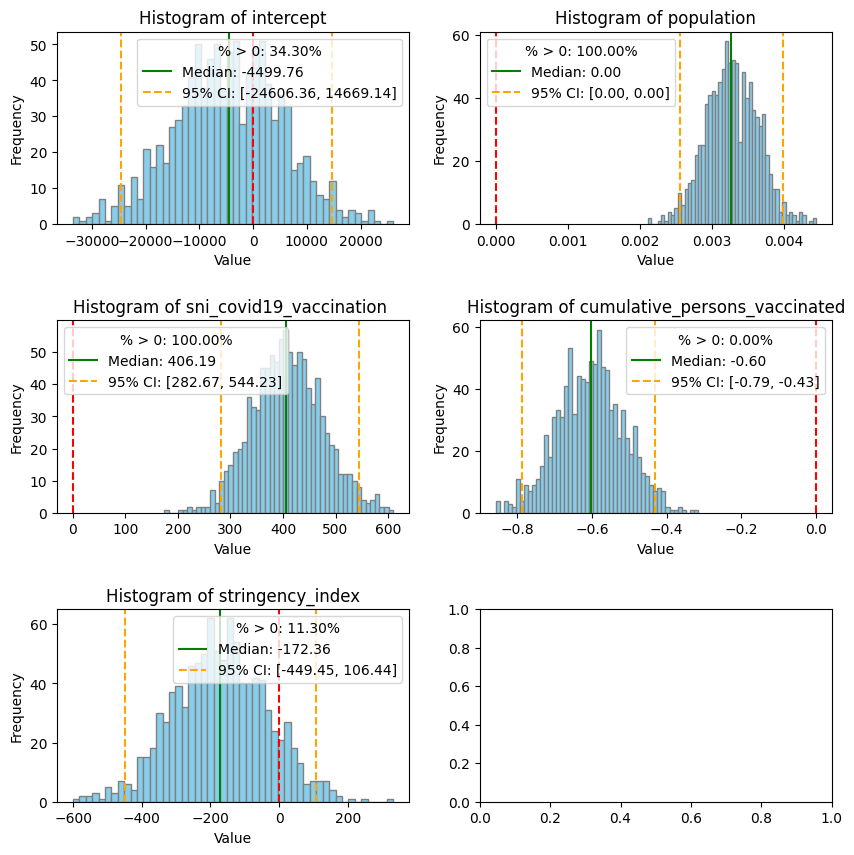

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Simulate values from empirical posterior distribution of model coefficients
n = 1000
coeff_samples = np.random.multivariate_normal(model.params, model.cov_params(), n)

#plot the histogram for each coefficient simulation
parameter_names = ['intercept', 'population', 'sni_covid19_vaccination ', 'cumulative_persons_vaccinated', 'stringency_index']
n_params = len(parameter_names)

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axes_flat = axs.flatten()

for i, name in enumerate(parameter_names):
    print(i, name)
    mean_val = np.mean(coeff_samples[:, i])
    median_val = np.median(coeff_samples[:, i])
    confidence_interval = np.percentile(coeff_samples[:, i], [2.5, 97.5])
    percent_positive = np.mean(coeff_samples[:, i] > 0) * 100  # Percentage of simulations > 0

    ax = axes_flat[i]
    ax.hist(coeff_samples[:, i], bins=50, color='skyblue', edgecolor='gray')
    ax.axvline(x=median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')
    ax.axvline(x=confidence_interval[0], color='orange', linestyle='--', label=f'95% CI: [{confidence_interval[0]:.2f}, {confidence_interval[1]:.2f}]')
    ax.axvline(x=confidence_interval[1], color='orange', linestyle='--')
    ax.axvline(x=0, color='red', linestyle='--')
    ax.set_title(f'Histogram of {name}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    ax.legend(title=f'% > 0: {percent_positive:.2f}%')

plt.subplots_adjust(hspace=0.5)
plt.show()

### Try train-test-split

In [49]:
# Merge vaccination_search, vaccination, government_response, loaction_key, and cases
merged_df = pd.merge(cases_per_state, vaccination_search_df, on=['location_key', 'date'])

# Merge the resulting dataframe with vaccination_df on the 'location_key' and 'date' column
merged_df = pd.merge(merged_df, vaccination_df, on=['location_key', 'date'])
merged_df_final = pd.merge(merged_df, government_df, on=['location_key', 'date'])

merged_df_final.dropna(inplace=True)

# Display the resulting DataFrame
display(merged_df_final)

,location_key,date,average_count,population,sni_covid19_vaccination,new_persons_vaccinated,stringency_index
0,Alaska,2021-01,1741.0,731545.0,60.884896,4525.187500,60.018387
1,Alaska,2021-02,999.0,731545.0,55.116815,2660.962963,57.870000
2,Alaska,2021-03,974.0,731545.0,74.260342,2644.387097,50.406452
3,Alaska,2021-04,1194.0,731545.0,52.763595,1889.466667,46.763333
4,Alaska,2021-05,618.0,731545.0,37.155872,1031.354839,42.130000
...,...,...,...,...,...,...,...
845,Wyoming,2022-01,5892.0,578759.0,32.042965,256.870968,37.960000
846,Wyoming,2022-02,2546.0,578759.0,9.253333,156.214286,39.743929
847,Wyoming,2022-03,291.0,578759.0,7.990414,75.064516,39.810000
848,Wyoming,2022-04,99.0,578759.0,7.072492,81.366667,39.810000


In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

state_dummies = pd.get_dummies(merged_df_final['location_key'], prefix ='state', drop_first=True)

merged_df_final = pd.concat([merged_df_final, state_dummies], axis=1)

# Define your design matrix and your target variable 
X = merged_df_final[['population', 'sni_covid19_vaccination','new_persons_vaccinated', 'stringency_index'] + state_dummies.columns.tolist()].astype(float) 
y = merged_df_final['average_count']

X = sm.add_constant(X)

# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Linear regression model
model = sm.OLS(y_train, X_train_scaled).fit()

# Get predictions
y_predictions = model.predict(X_test)

# Check model accuracy
mse = mean_squared_error(y_test, y_predictions)
r2 = r2_score(y_test, y_predictions)

print(model.summary())
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

                                 OLS Regression Results                                
Dep. Variable:          average_count   R-squared (uncentered):                   0.270
Model:                            OLS   Adj. R-squared (uncentered):              0.205
Method:                 Least Squares   F-statistic:                              4.158
Date:                Tue, 27 Feb 2024   Prob (F-statistic):                    7.38e-18
Time:                        12:46:46   Log-Likelihood:                         -7581.0
No. Observations:                 637   AIC:                                  1.527e+04
Df Residuals:                     585   BIC:                                  1.550e+04
Df Model:                          52                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [51]:
# Actual vs predicted values, visualization"
"""
sns.scatterplot(x=y_test.flatten(), y=y_transformed.flatten())
plt.plot(y_test.flatten(), y_test.flatten(), color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()"""

"\nsns.scatterplot(x=y_test.flatten(), y=y_transformed.flatten())\nplt.plot(y_test.flatten(), y_test.flatten(), color='red', linestyle='--')\nplt.title('Actual vs Predicted Values')\nplt.xlabel('Actual Values')\nplt.ylabel('Predicted Values')\nplt.show()"